# Non-Anthropomorphic Hand Data Loading and Plotting

In [1]:
# Set up:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# import plotly.graph_objects as go
# import plotly.express as px
# import ipywidgets as widget

# Computation packages
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from fastdtw import fastdtw

In [2]:
from nah.loader import load_raw_csv_data, load_npzs
from nah.utils import norm_data, full_align, clean_rot_data, segment_by_demo,sum_of_squares
from nah.trajectory import get_evo_trajectory, get_evo_metrics, evo_sync, convert_evo_to_np, evaluate_ape
from nah.plot import plot_norm, plot_pos, plot_rot, plot_raw_data,view_participant_robot_gesture, plot_heatmap
from nah.alignments import evo_align, Alignment
from nah.datagraphs import generate_hand_endeff_similarity_matrix

In [3]:
# Functions are all defined. Let's grab some data sets and get them ordered
""" UNCOMMENT THIS SECTION IF YOU WANT IT TO RUN. I GENERATED ALL THE NPZ FILES ALREADY, 
AND I DID NOT WANT TO RE-RUN THIS (SINCE THE SAVE-FILE SOMETIMES FAILS) AND MESS
THEM UP.
"""

# gesture_num=0
# demo_num = 1

# robot_name = "Reachy"
# end_eff_name = "r_wrist2hand_"

# # robot_name = "j2s6s300"
# # end_eff_name = "j2s6s300_end_effector_"

# total_end_eff_data = np.array([])
# total_camera_data  = np.array([])
# total_rh_data      = np.array([])
# total_lh_data      = np.array([])
# total_joint_data   = np.array([])

# start_index = 1 
# end_index = -1 
# # start_index = 77
# # end_index = -154

# followup = False

# if followup:
#     PIDmax=10
#     gesturemax = 7
# else:
#     PIDmax=17
#     gesturemax=16

# gest_target = 4
   

# for PID in range(1,PIDmax):
# # for PID in range(3,4):
    
#     for gesture_num in range(1,gesturemax):
#     # for gesture_num in range(gest_target,gest_target+1):
        
#         for demo_num in range(1,6): # Change this to include all demos that exist (and possibly exclude individual ones)
#             # print(gesture_num, demo_num)
            
#             # LIST OF OVERRIDES:
#             # These are robots/participants that had erroneous or incomplete data. Two cases exist:
#             #  1) The user recorded a demo that they later wished to replace with an extra recording. 
#             #     The robot, PID, and gesture to omit/gesture to replace must be specified.
#             #     The easy way to do this would be to just grab the last five demos for each gesture,
#             #     but that's not 100% accurate. It was not always the first demo that was the mess-up.
#             #  2) The robot spazzed out and the user was unable to finish all gestures or motions. 
#             #     I don't think we can account for that here; I think this will affect clustering, workspace 
#             #     coverage, and metrics of user consistency, but that's going to show up later.
            
#             if not followup:
#                 if robot_name[0]=='R':
#                     if (PID==2 and gesture_num==1):
#                         print("Correcting PID 2, gesture 1")
#                         demo_num += 10  #PID2 recorded many extra motions before settling on the last five to show
#                     elif (PID==9 and gesture_num==4 and demo_num==1):
#                         print("Correcting PID 9, gesture 4, demo 1")
#                         demo_num = 6
#                     elif (PID==16 and gesture_num==11):
#                         print("Correcting PID 16, gesture 11")
#                         demo_num += 5
#                     elif (PID==16 and gesture_num==12):
#                         print("Correcting PID 16, gesture 12")
#                         demo_num += 6
#                 elif robot_name[0]=='j':
#                     if (PID==11 and gesture_num==3 and demo_num==1):
#                         print("Correcting PID 11, gesture 3, demo 1")
#                         demo_num = 6
#                     elif (PID==12 and gesture_num==1 and demo_num==1):
#                         print("Correcting PID 12, gesture 1, demo 1")
#                         demo_num = 6
#                     elif (PID==12 and gesture_num==4):
#                         print("Correcting PID 12, gesture 4")
#                         demo_num += 2
#                     elif (PID==16 and gesture_num==11):
#                         print("Correcting PID 16, gesture 11")
#                         demo_num += 1

#             print(PID, gesture_num, demo_num)
            
#             try:
#                 end_eff_data_temp = load_raw_csv_data(robot_name,end_eff_name, PID, followup, gesture_num, demo_num)
#                 camera_data_temp  = load_raw_csv_data(robot_name,"Main Camera_", PID, followup, gesture_num, demo_num)
#                 rh_data_temp      = load_raw_csv_data(robot_name,"RightHand Controller_", PID, followup, gesture_num, demo_num)
#                 lh_data_temp      = load_raw_csv_data(robot_name,"LeftHand Controller_", PID, followup, gesture_num, demo_num)
#                 joint_data_temp   = load_raw_csv_data(robot_name,"Joint", PID, followup, gesture_num, demo_num)
    
#                 # I wanted to move this out of the try/catch statement, but then the variable names were out of scope
#                 end_eff_data_temp[:,0] = end_eff_data_temp[:,0]-end_eff_data_temp[0,0]
#                 camera_data_temp[:,0]  = camera_data_temp[:,0]-camera_data_temp[0,0]
#                 rh_data_temp[:,0]      = rh_data_temp[:,0]-rh_data_temp[0,0]
#                 lh_data_temp[:,0]      = lh_data_temp[:,0]-lh_data_temp[0,0]
#                 joint_data_temp[:,0]   = joint_data_temp[:,0]-joint_data_temp[0,0]
                
#                 end_eff_data_temp = end_eff_data_temp[start_index:end_index,:]
#                 camera_data_temp  = camera_data_temp[start_index:end_index,:]
#                 rh_data_temp      = rh_data_temp[start_index:end_index,:]
#                 lh_data_temp      = lh_data_temp[start_index:end_index,:]
#                 joint_data_temp   = joint_data_temp[start_index:end_index,:]
#             except:
#                 error_message = "Import data failed for PID "+ str(PID)+", gesture "+str(gesture_num)+", demo_num "+str(demo_num)
#                 # raise RuntimeError(error_message)
#                 print(error_message)

#             # More participant-specific exceptions:
#             if (PID==3 and not followup):
#                 if (gesture_num>=3):
#                     holding_variable = rh_data_temp
#                     rh_data_temp = lh_data_temp
#                     lh_data_temp = holding_variable
#             # Normalize by participant wingspan
#             # ...
           
#             try:
#                 if (demo_num==1):
#                     end_eff_data = end_eff_data_temp
#                     camera_data  = camera_data_temp
#                     rh_data      = rh_data_temp
#                     lh_data      = lh_data_temp
#                     joint_data   = joint_data_temp
#                 else:   
#                     end_eff_data = np.vstack((end_eff_data, end_eff_data_temp))
#                     camera_data  = np.vstack((camera_data, camera_data_temp))
#                     rh_data      = np.vstack((rh_data, rh_data_temp))
#                     lh_data      = np.vstack((lh_data, lh_data_temp))
#                     joint_data  = np.vstack((joint_data, joint_data_temp))
#             except:
#                 print("Stacking data for demo "+str(demo_num)+" failed")
    
#             try:
#                 if followup:
#                     np.savez('C:\\Users\\jmoln\\Dropbox (GaTech)\\Non-Anthropomorphic Hands User Study Data\\npz files\\data_PID'+str(PID)+"B_"+str(robot_name)+"_gesture_"+str(gesture_num),\
#                              end_eff_data=end_eff_data,rh_data=rh_data,lh_data=lh_data,\
#                              camera_data=camera_data,joint_data=joint_data)
#                 else:
#                     np.savez('C:\\Users\\jmoln\\Dropbox (GaTech)\\Non-Anthropomorphic Hands User Study Data\\npz files\\data_PID'+str(PID)+"_"+str(robot_name)+"_gesture_"+str(gesture_num),\
#                              end_eff_data=end_eff_data,rh_data=rh_data,lh_data=lh_data,\
#                              camera_data=camera_data,joint_data=joint_data)
   
#             except: 
#                 print("Save data failed")
#                 raise

#         # try:    
#         #     if ((PID==1) & (gesture_num==gest_target)):
#         #         total_end_eff_data = end_eff_data
#         #         total_camera_data = camera_data
#         #         total_rh_data     = rh_data
#         #         total_lh_data     = lh_data
#         #         total_joint_data  = joint_data
#         #     else:
#         #         total_end_eff_data = np.vstack((total_end_eff_data,end_eff_data))
#         #         total_camera_data  = np.vstack((total_camera_data,camera_data))
#         #         total_rh_data      = np.vstack((total_rh_data,rh_data))
#         #         total_lh_data      = np.vstack((total_lh_data,lh_data))
#         #         total_joint_data   = np.vstack((total_joint_data,joint_data))
#         # except:
#         #     print("Data was missing from PID"+str(PID)+" gesture "+str(gesture_num))

# # plot_raw_data(total_end_eff_data, total_rh_data, total_lh_data, total_camera_data, total_joint_data, start_index, end_index)



' UNCOMMENT THIS SECTION IF YOU WANT IT TO RUN. I GENERATED ALL THE NPZ FILES ALREADY, \nAND I DID NOT WANT TO RE-RUN THIS (SINCE THE SAVE-FILE SOMETIMES FAILS) AND MESS\nTHEM UP.\n'

100%|██████████| 2/2 [00:00<00:00, 517.05it/s]


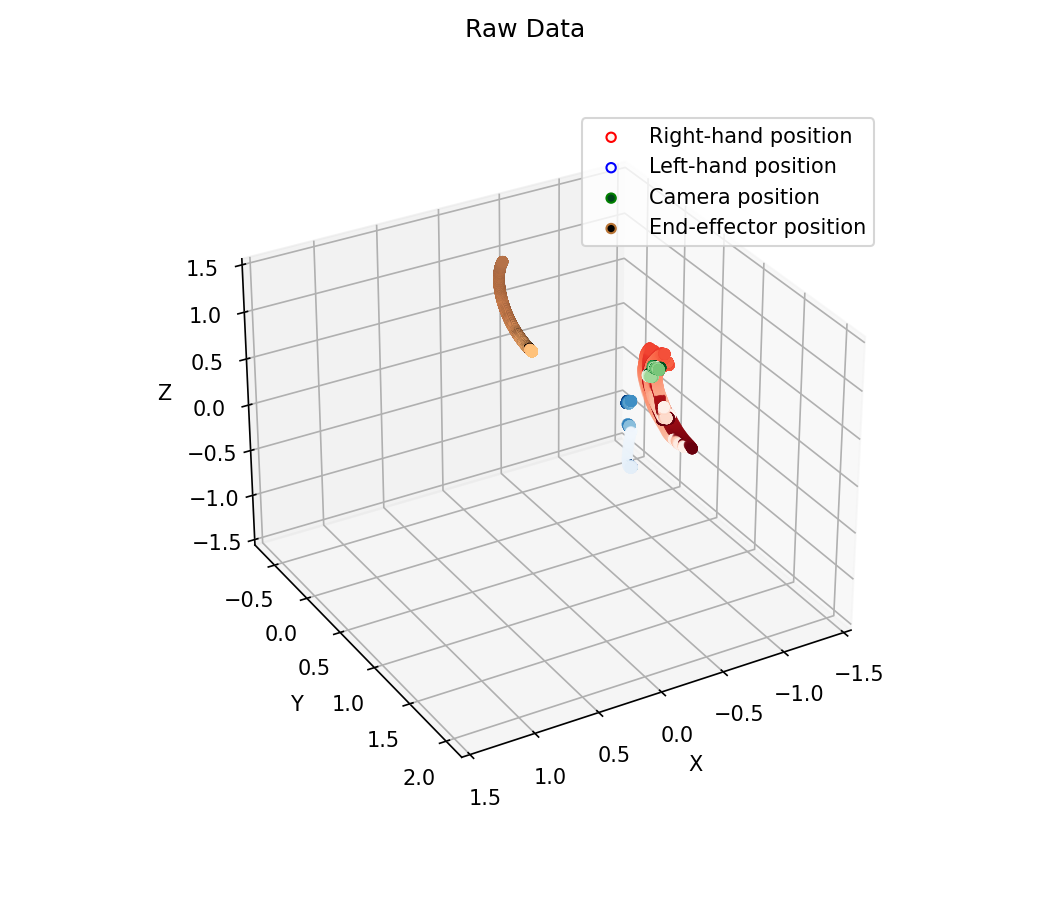

In [3]:
%matplotlib widget
plt.close("all")
# robot_name='j2s6s300'
robot_name='Reachy'
participant_ids = (11,12)
gesture_num=1
followup = False

view_participant_robot_gesture(robot_name,participant_ids,gesture_num,followup,centered=False)

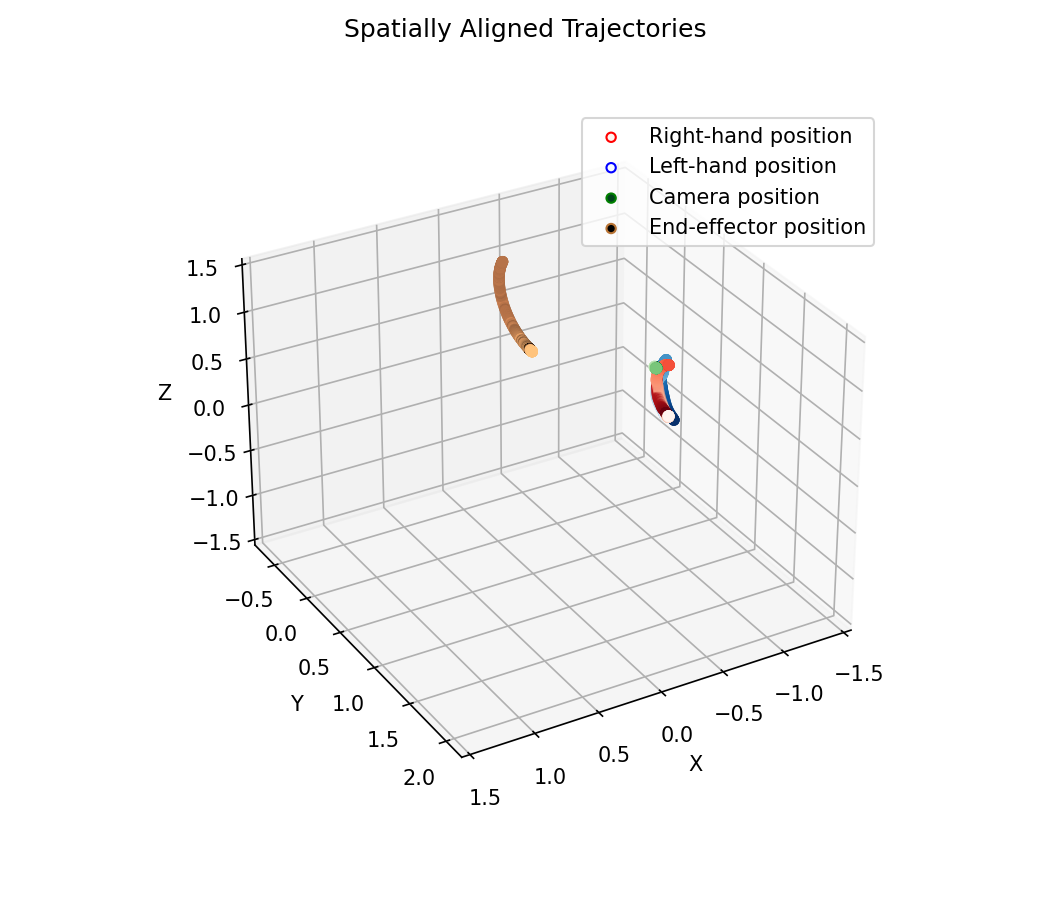

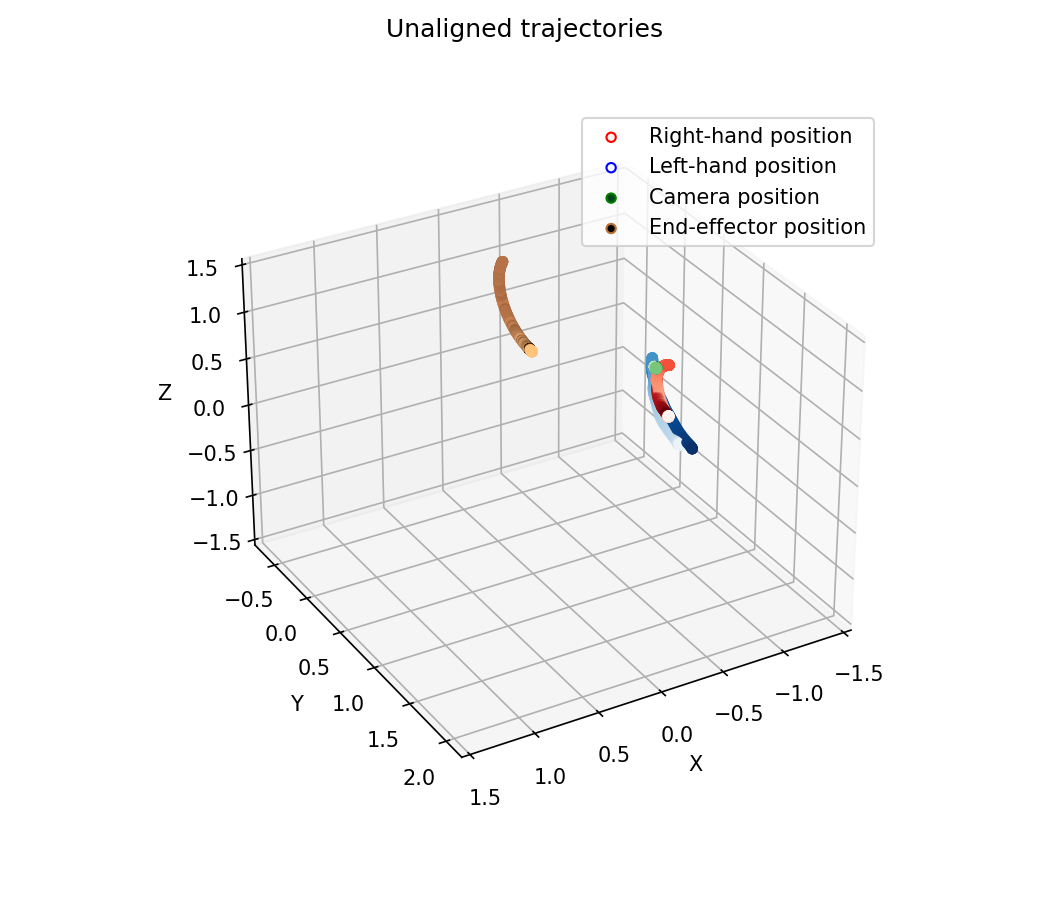

In [8]:
participant_1 = 11
participant_2 = 12
followup = False
gesture_num = 1
demo_max = 5

end_eff_data1, camera_data1, rh_data1, lh_data1, joint_data1 = load_npzs(robot_name, participant_1, followup, gesture_num)
end_eff1, camera1, rh1, lh1, joint1 = segment_by_demo(end_eff_data1, camera_data1,
                                                     rh_data1, lh_data1,
                                                     joint_data1, demo_max)
end_eff_data2, camera_data2, rh_data2, lh_data2, joint_data2 = load_npzs(robot_name, participant_2, followup, gesture_num)
end_eff2, camera2, rh2, lh2, joint2 = segment_by_demo(end_eff_data2, camera_data2,
                                                     rh_data2, lh_data2,
                                                     joint_data2, demo_max)

traj1 = rh1
traj2 = rh2
    

demo=1
plot_raw_data(1,
            end_eff1[demo],
            camera1[demo],
            traj1[demo],
            traj2[demo],
            joint1[demo],
            title="Unaligned trajectories")

traj1_traj = get_evo_trajectory(traj1[demo])
traj2_traj = get_evo_trajectory(traj2[demo])

# Just align without doing explicit timestamp matching.
traj2_traj_aligned = evo_align(traj1_traj, traj2_traj)

plot_raw_data(1,
            end_eff1[demo],
            camera1[demo],
            convert_evo_to_np(traj1_traj),
            convert_evo_to_np(traj2_traj_aligned),
            joint1[demo],
            title="Spatially Aligned Trajectories")

plt.show()

Gesture 6: Failed to get metrics for participant 1 demo 3.
 Retrying...
Gesture 6: Failed to get metrics for participant 1 demo 3.
 Retrying...
Gesture 9: Failed to get metrics for participant 1 demo 5.
 Retrying...
Gesture 10: Failed to get metrics for participant 1 demo 2.
 Retrying...
Gesture 3: Failed to get metrics for participant 2 demo 3.
 Retrying...
Gesture 3: Failed to get metrics for participant 2 demo 3.
 Retrying...
Gesture 6: Failed to get metrics for participant 2 demo 3.
 Retrying...
Gesture 6: Failed to get metrics for participant 2 demo 3.
 Retrying...
Gesture 10: Failed to get metrics for participant 2 demo 4.
 Retrying...
Gesture 3: Failed to get metrics for participant 3 demo 2.
 Retrying...
Gesture 6: Failed to get metrics for participant 3 demo 2.
 Retrying...
Gesture 9: Failed to get metrics for participant 3 demo 5.
 Retrying...
Gesture 10: Failed to get metrics for participant 3 demo 3.
 Retrying...
Gesture 3: Failed to get metrics for participant 4 demo 1.
 R

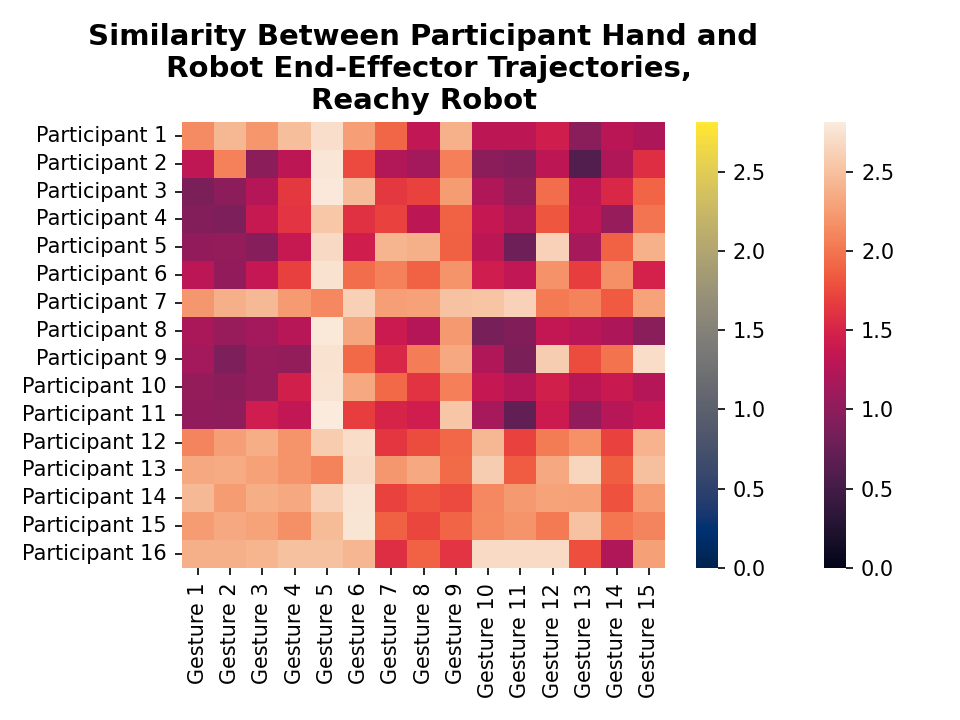

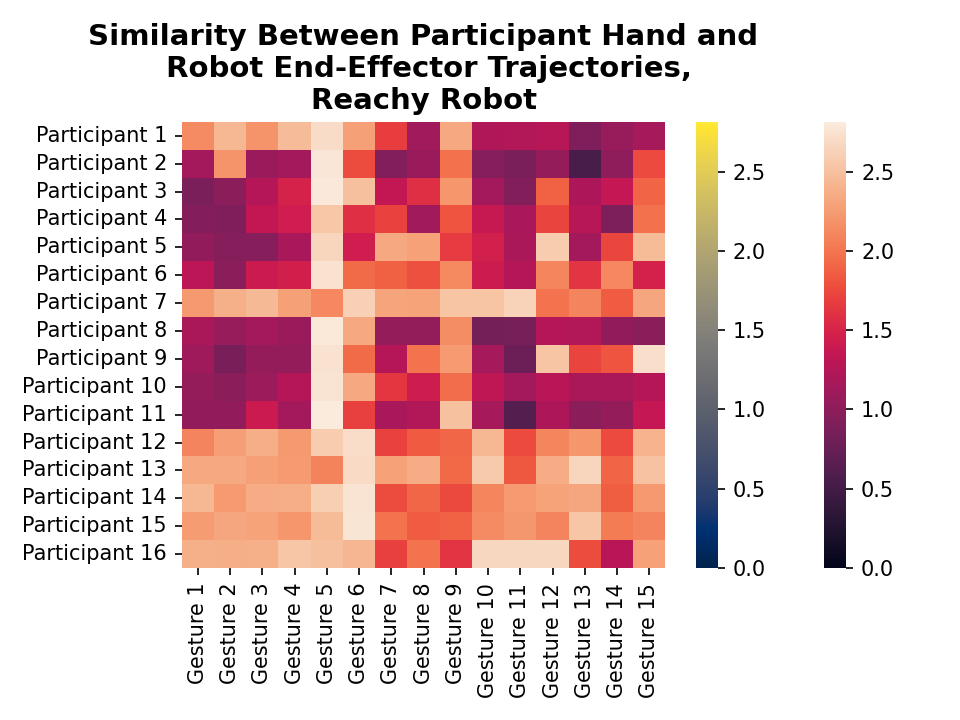

Gesture 1: Failed to get metrics for participant 2 demo 2.
 Retrying...
Gesture 6: Failed to get metrics for participant 2 demo 1.
 Retrying...
Gesture 6: Failed to get metrics for participant 2 demo 4.
 Retrying...
Gesture 11: Failed to get metrics for participant 5 demo 4.
 Retrying...
Gesture 9: Failed to get metrics for participant 12 demo 2.
 Retrying...


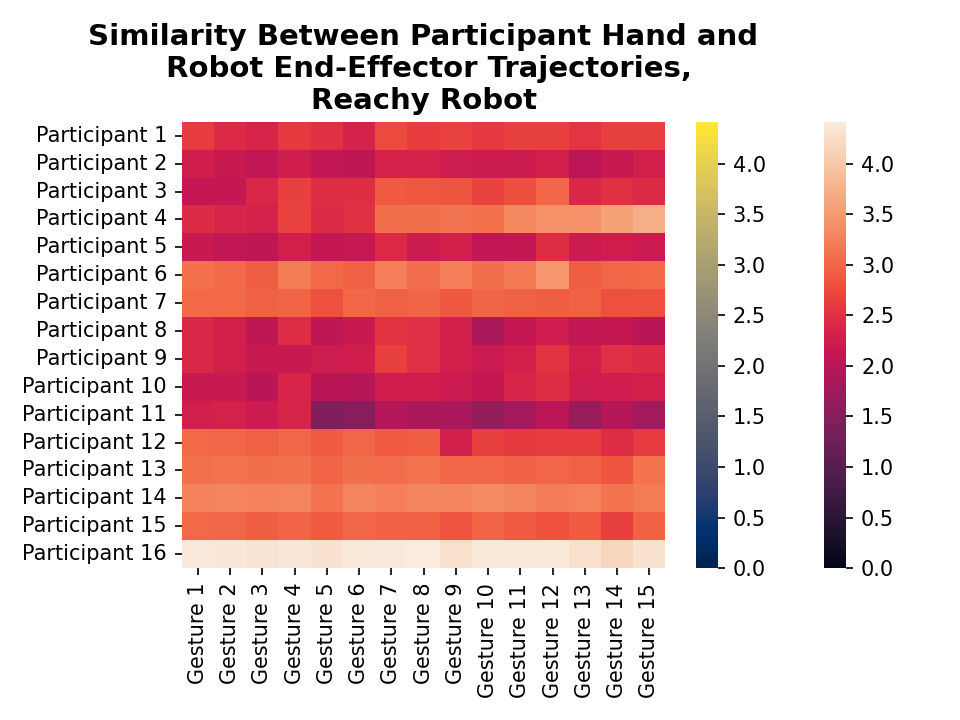

Gesture 2: Failed to get metrics for participant 1 demo 1.
 Retrying...
PID 1 is missing demos for gesture 14.
PID 2 is missing demos for gesture 11.
Gesture 9: Failed to get metrics for participant 3 demo 3.
 Retrying...
Gesture 1: Failed to get metrics for participant 4 demo 2.
 Retrying...
Gesture 5: Failed to get metrics for participant 5 demo 5.
 Retrying...
PID 7 is missing demos for gesture 11.
Gesture 10: Failed to get metrics for participant 8 demo 1.
 Retrying...
PID 8 is missing demos for gesture 11.
Gesture 8: Failed to get metrics for participant 10 demo 3.
 Retrying...
Gesture 15: Failed to get metrics for participant 10 demo 1.
 Retrying...
Gesture 9: Failed to get metrics for participant 12 demo 1.
 Retrying...
Gesture 12: Failed to get metrics for participant 13 demo 1.
 Retrying...
PID 14 is missing demos for gesture 15.


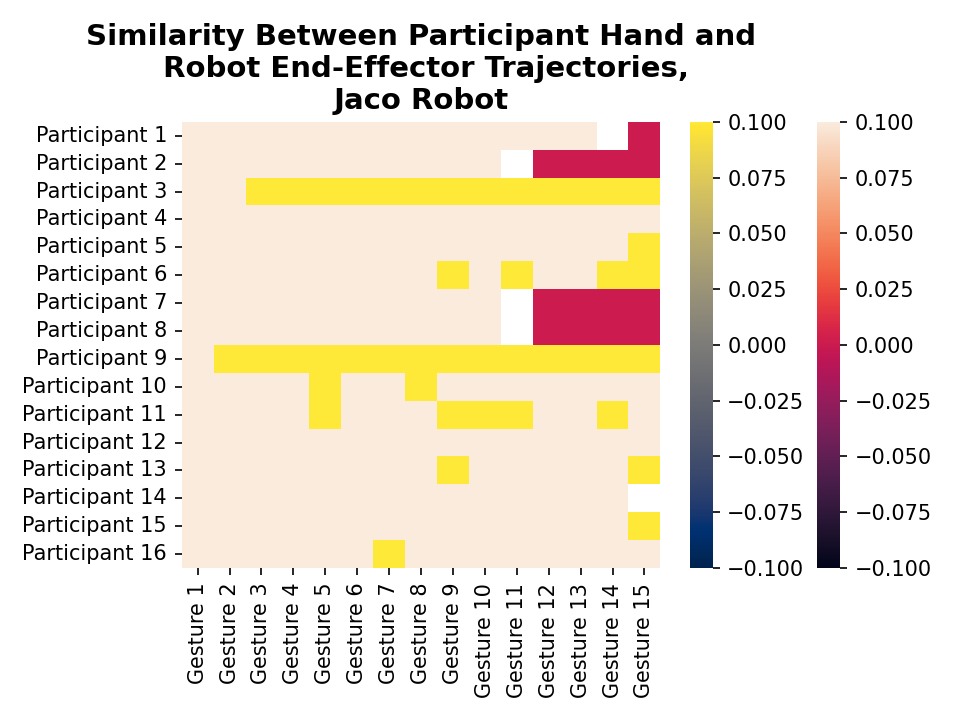

PID 1 is missing demos for gesture 14.
PID 2 is missing demos for gesture 11.
PID 7 is missing demos for gesture 11.
PID 8 is missing demos for gesture 11.
PID 14 is missing demos for gesture 15.


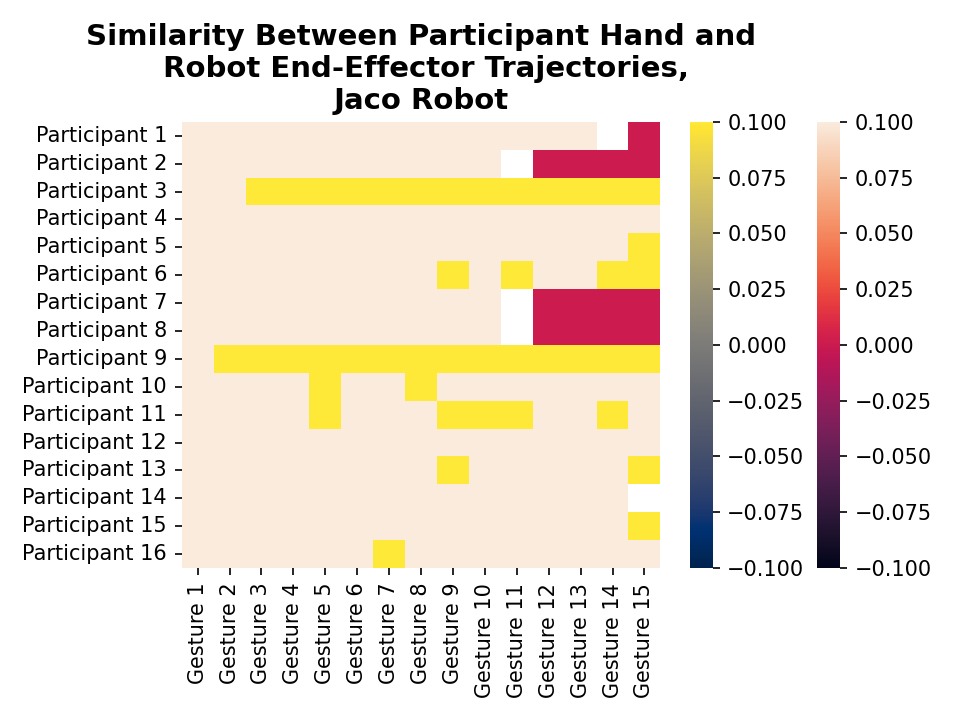

PID 1 is missing demos for gesture 14.
PID 2 is missing demos for gesture 11.
Gesture 15: Failed to get metrics for participant 4 demo 1.
 Retrying...
PID 7 is missing demos for gesture 11.
PID 8 is missing demos for gesture 11.
Gesture 9: Failed to get metrics for participant 14 demo 1.
 Retrying...
PID 14 is missing demos for gesture 15.
Gesture 8: Failed to get metrics for participant 15 demo 3.
 Retrying...


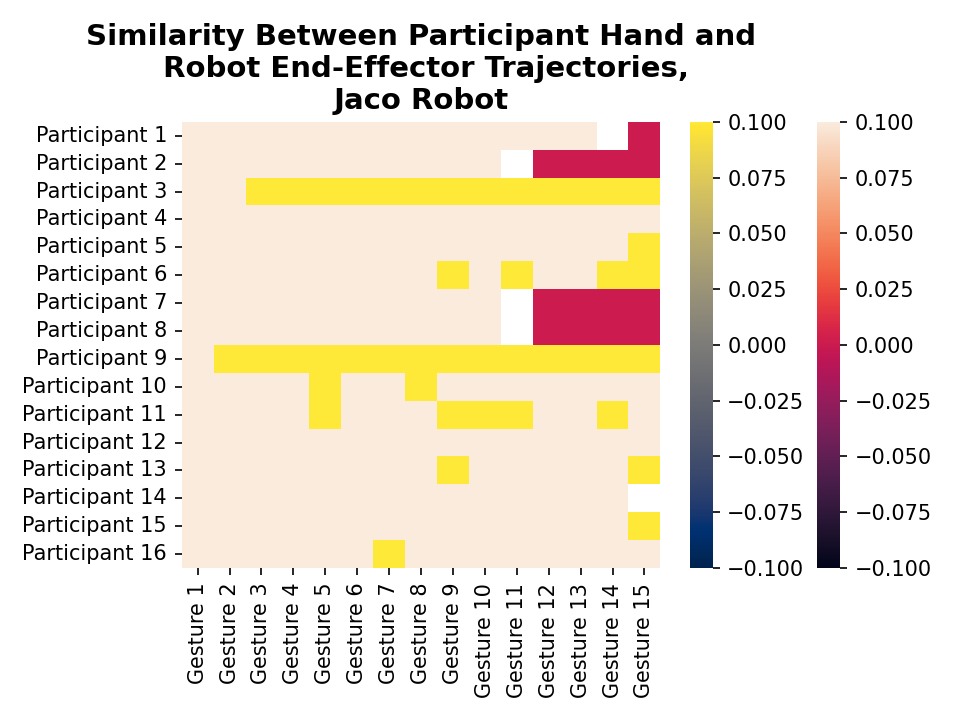